In [1]:
# system and utility imports
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

# sklearn metrics and utilities
from sklearn.metrics import (
    roc_curve, roc_auc_score, precision_recall_curve, 
    average_precision_score, accuracy_score, confusion_matrix, 
    classification_report, auc, log_loss, precision_score, 
    recall_score, f1_score
)
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

# tensorFlow and keras model utilities
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, optimizers, backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# tensorFlow and keras layers
from tensorflow.keras.layers import (
    Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, 
    Conv2DTranspose, Activation, LeakyReLU, UpSampling2D, 
    Conv2D, MaxPooling2D, ReLU
)

# image preprocessing
from tensorflow.keras.preprocessing.image import (
    load_img, img_to_array, ImageDataGenerator
)

# regularization
from keras.regularizers import l2

In [2]:
# function to check if a file is an image
def is_image_file(filename):
    return filename.lower().endswith('.jpg')

In [3]:
# function to load and preprocess an image
def load_and_preprocess_image(img_path, target_size=(128, 128)):
    # load image
    image = Image.open(img_path)
    
    # resize image to target size
    image = image.resize(target_size)
    
    # convert image to array and normalize (pixel values between 0 and 1)
    image = np.array(image) / 255.0
    
    # ensure image has 3 channels (RGB)
    if len(image.shape) == 2:  # If grayscale, convert to RGB
        image = np.stack((image,) * 3, axis=-1)
    elif image.shape[2] == 4:  # If RGBA, convert to RGB
        image = image[:, :, :3]
    
    return image

In [4]:
# function to load images from a directory and assign labels
def load_images_from_directory(directory, label):
    images = []
    labels = []
    for root, _, files in os.walk(directory):
        for file in files:
            if is_image_file(file):
                img_path = os.path.join(root, file)
                image = load_and_preprocess_image(img_path)  # Load and preprocess
                images.append(image)
                labels.append(label)
    return np.array(images), np.array(labels)

In [5]:
# base directory for the dataset
directory = 'vehicle_insurance_dataset'

# set paths for training data subdirectories
train_fraud_dir = os.path.join(directory, 'train', 'fraud')
train_non_fraud_dir = os.path.join(directory, 'train', 'non-fraud')

# load and label the training images for fraud and non-fraud cases
train_images_fraud, train_labels_fraud = load_images_from_directory(train_fraud_dir, 1)
train_images_non_fraud, train_labels_non_fraud = load_images_from_directory(train_non_fraud_dir, 0)

print(f"Train images (fraud) shape: {train_images_fraud.shape}")
print(f"Train labels (fraud) shape: {train_labels_fraud.shape}")
print(f"Train images (non-fraud) shape: {train_images_non_fraud.shape}")
print(f"Train labels (non-fraud) shape: {train_labels_non_fraud.shape}")

Train images (fraud) shape: (372, 128, 128, 3)
Train labels (fraud) shape: (372,)
Train images (non-fraud) shape: (6091, 128, 128, 3)
Train labels (non-fraud) shape: (6091,)


In [6]:
# load fraud and non-fraud images from the train directories
fraud_images = train_images_fraud
non_fraud_images = train_images_non_fraud

In [7]:
# function to denoise
def denoise_images_with_dcae(fraud_images, non_fraud_images, dcae_model_path):
    # load the DCAE model for denoising
    dcae_model = load_model(dcae_model_path)
    print("DCAE model loaded.")

    # denoising fraud and non-fraud images
    fraud_images_denoised = dcae_model.predict(fraud_images)
    non_fraud_images_denoised = dcae_model.predict(non_fraud_images)

    # print the shape of the denoised datasets
    print(f"Denoised Fraud dataset shape: {fraud_images_denoised.shape}")
    print(f"Denoised Non-Fraud dataset shape: {non_fraud_images_denoised.shape}")

    return fraud_images_denoised, non_fraud_images_denoised

In [8]:
# define the function for aggressive augmentation of fraud images
def augment_fraud_images(fraud_images):
    datagen_fraud = ImageDataGenerator(
        rotation_range=40,  # aggressive rotation
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    # generate augmented images
    augmented_fraud_images = []
    for img in fraud_images:
        img = img.reshape((1,) + img.shape)  # reshape for the generator
        for _ in range(10):  # generate 10 augmented images per fraud image
            aug_img = next(datagen_fraud.flow(img))
            augmented_fraud_images.append(aug_img[0])  # take the first image

    return np.array(augmented_fraud_images)

# augment the fraud images more aggressively
augmented_fraud_images = augment_fraud_images(fraud_images)

# combine original fraud images with augmented fraud images
combined_fraud_images = np.vstack((fraud_images, augmented_fraud_images))

In [32]:
def balance_dataset(fraud_images, non_fraud_images, generator_model_path):
    # determine the needed fraud count
    desired_fraud_count = non_fraud_images.shape[0]  # Total count of non-fraud images
    current_fraud_count = fraud_images.shape[0]      # Current count of fraud images
    needed_fraud_images = desired_fraud_count - current_fraud_count  # Calculate needed fraud images

    print("Desired_fraud_count: ", desired_fraud_count)
    print("Current_fraud_count: ", current_fraud_count)
    print("Needed_fraud_images: ", needed_fraud_images)

    # load the generator model
    generator = load_model(generator_model_path)
    print("Generator loaded.")

    # generate synthetic fraud images if needed
    if needed_fraud_images > 0:
        noise = np.random.normal(0, 1, (needed_fraud_images, 100))  # generate noise for needed images
        synthetic_fraud_images = generator.predict(noise)
        synthetic_fraud_images = 0.5 * synthetic_fraud_images + 0.5 
    else:
        print("No need to generate synthetic fraud images; the dataset is already balanced.")
        synthetic_fraud_images = np.array([])  # Handle accordingly

    print(f"Synthetic Fraud dataset shape: {synthetic_fraud_images.shape}")

    # combine original and synthetic fraud images
    balanced_fraud_images = np.vstack((fraud_images, synthetic_fraud_images))  # combine original and synthetic fraud images
    balanced_images = np.vstack((balanced_fraud_images, non_fraud_images))  # combine fraud and non-fraud images
    balanced_training_labels = np.hstack((np.ones(balanced_fraud_images.shape[0]), np.zeros(non_fraud_images.shape[0])))  # create labels

    # print new shapes
    print(f"Combined training dataset shape: {balanced_images.shape}")
    print(f"Combined training label dataset shape: {balanced_training_labels.shape}")
    print(f"New fraud dataset shape: {balanced_fraud_images.shape}")
    print(f"Non-fraud dataset shape: {non_fraud_images.shape}")

    # shuffle the data
    indices = np.arange(balanced_images.shape[0])  # Generate an array of indices
    np.random.shuffle(indices)  # Shuffle the indices

    # reorder the images and labels according to the shuffled indices
    balanced_images = balanced_images[indices]
    balanced_training_labels = balanced_training_labels[indices]

    return balanced_images, balanced_training_labels

In [34]:
# balance the dataset by generating synthetic fraud images
balanced_images, balanced_train_labels = balance_dataset(
    combined_fraud_images, 
    non_fraud_images, 
    'generator_model.keras'
)

Desired_fraud_count:  6091
Current_fraud_count:  4092
Needed_fraud_images:  1999
Generator loaded.
63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 630ms/step
Synthetic Fraud dataset shape: (1999, 128, 128, 3)
Combined training dataset shape: (12182, 128, 128, 3)
Combined training label dataset shape: (12182,)
New fraud dataset shape: (6091, 128, 128, 3)
Non-fraud dataset shape: (6091, 128, 128, 3)


In [35]:
# calculate the number of fraud images (real + synthetic) in the balanced dataset
num_fraud_images = len(combined_fraud_images)  

# split the balanced images into fraud and non-fraud sets
balanced_fraud_images = balanced_images[:num_fraud_images]
balanced_non_fraud_images = balanced_images[num_fraud_images:]

In [36]:
# denoise the balanced fraud and non-fraud images
fraud_images_denoised, non_fraud_images_denoised = denoise_images_with_dcae(
    balanced_fraud_images, 
    balanced_non_fraud_images, 
    'dcae_model.keras'
)

DCAE model loaded.
128/128 ━━━━━━━━━━━━━━━━━━━━ 19s 145ms/step
253/253 ━━━━━━━━━━━━━━━━━━━━ 37s 145ms/step
Denoised Fraud dataset shape: (4092, 128, 128, 3)
Denoised Non-Fraud dataset shape: (8090, 128, 128, 3)


In [37]:
# combine denoised fraud and non-fraud images, and shuffle
balanced_images = np.vstack((fraud_images_denoised, non_fraud_images_denoised))
indices = np.arange(balanced_images.shape[0])
np.random.shuffle(indices)

balanced_images = balanced_images[indices]
balanced_train_labels = balanced_train_labels[indices]

# verify the shape of generated images
print(f"Combined Fraud & Non-Fraud train dataset shape: {balanced_images.shape}")
print(f"Combined Fraud & Non-Fraud train label dataset shape: {balanced_train_labels.shape}")

Combined Fraud & Non-Fraud train dataset shape: (12182, 128, 128, 3)
Combined Fraud & Non-Fraud train label dataset shape: (12182,)


In [58]:
def build_classification_model(input_shape):
    model = Sequential([
        Input(shape=input_shape), 
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)), 
        Dropout(0.5),  
        Dense(1, activation='sigmoid')
    ])
    return model

# define input shape of images
input_shape = (128, 128, 3)

# create the model
model_cnn = build_classification_model(input_shape)

# compile the model with a lower learning rate
model_cnn.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [60]:
# stratified sampling to ensure class distribution is maintained
X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(balanced_images, balanced_train_labels, test_size=0.2,random_state=42, 
    stratify=balanced_train_labels 
)

# check the shape of the training and validation datasets
print(f"Training set shape (images): {X_train_cnn.shape}")
print(f"Validation set shape (images): {X_val_cnn.shape}")
print(f"Training set shape (labels): {y_train_cnn.shape}")
print(f"Validation set shape (labels): {y_val_cnn.shape}")

# check the class distribution in both training and validation sets
unique_train, counts_train = np.unique(y_train_cnn, return_counts=True)
unique_val, counts_val = np.unique(y_val_cnn, return_counts=True)

print(f"Training set class distribution: {dict(zip(unique_train, counts_train))}")
print(f"Validation set class distribution: {dict(zip(unique_val, counts_val))}")

Training set shape (images): (9745, 128, 128, 3)
Validation set shape (images): (2437, 128, 128, 3)
Training set shape (labels): (9745,)
Validation set shape (labels): (2437,)
Training set class distribution: {0.0: 4872, 1.0: 4873}
Validation set class distribution: {0.0: 1219, 1.0: 1218}


In [61]:
# early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('combined_gan_aug_cnn_best_model.keras', monitor='val_accuracy', save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5)

# calculate class weights based on the original balanced data
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(balanced_train_labels), y=balanced_train_labels)
class_weights_dict = dict(enumerate(class_weights))

# manually adjust the weight for class 1 (fraud)
class_weights_dict[1] *= 2.2  # increase weight of class 1 (fraud)
print(f"Adjusted Class Weights: {class_weights_dict}")

# train the CNN model with class weights to handle imbalance
history = model_cnn.fit(balanced_images, balanced_train_labels, validation_data=(X_val_cnn, y_val_cnn),
    epochs=30,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler],
    class_weight=class_weights_dict,
    verbose=1
)

# save the model after training
print("Saving the model as combined_gan_aug_cnn_model_classification.keras...")
model_cnn.save('combined_gan_aug_cnn_model_classification.keras.keras')

# evaluate the model
loss, accuracy = model_cnn.evaluate(X_val_cnn, y_val_cnn)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

Adjusted Class Weights: {0: 1.0, 1: 2.2}
Epoch 1/30
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 118ms/step - accuracy: 0.5190 - loss: 3.0747 - val_accuracy: 0.5975 - val_loss: 1.2353 - learning_rate: 1.0000e-04
Epoch 2/30
381/381 ━━━━━━━━━━━━━━━━━━━━ 44s 115ms/step - accuracy: 0.5590 - loss: 1.3822 - val_accuracy: 0.5749 - val_loss: 0.9977 - learning_rate: 1.0000e-04
Epoch 3/30
381/381 ━━━━━━━━━━━━━━━━━━━━ 44s 114ms/step - accuracy: 0.5771 - loss: 1.1562 - val_accuracy: 0.5720 - val_loss: 0.8792 - learning_rate: 1.0000e-04
Epoch 4/30
381/381 ━━━━━━━━━━━━━━━━━━━━ 44s 115ms/step - accuracy: 0.5880 - loss: 1.0694 - val_accuracy: 0.6196 - val_loss: 0.8131 - learning_rate: 1.0000e-04
Epoch 5/30
381/381 ━━━━━━━━━━━━━━━━━━━━ 44s 115ms/step - accuracy: 0.6095 - loss: 1.0146 - val_accuracy: 0.6176 - val_loss: 0.8007 - learning_rate: 1.0000e-04
Epoch 6/30
381/381 ━━━━━━━━━━━━━━━━━━━━ 44s 115ms/step - accuracy: 0.6316 - loss: 0.9823 - val_accuracy: 0.6557 - val_loss: 0.7647 - learning_rate: 1.0000e-04
Epoch

In [63]:
# print the model summary
model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,914,309 (37.82 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,609,540 (25.21 MB)

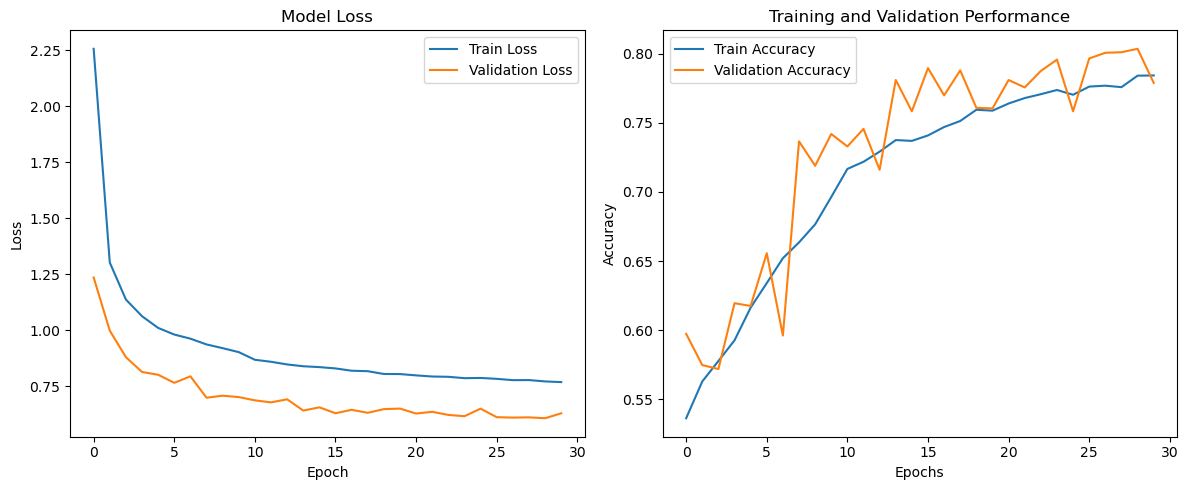

In [64]:
# create a figure for the loss plot
plt.figure(figsize=(12, 5))

# plot training & validation loss values
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# plot training & validation accuracy values
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Performance')

# show the combined plots
plt.tight_layout()  
plt.show()

In [75]:
# set paths to the test directories
test_fraud_dir = os.path.join(directory, 'test','fraud')
test_non_fraud_dir = os.path.join(directory,'test', 'non-fraud')

# load and label the test images
test_images_fraud, test_labels_fraud = load_images_from_directory(test_fraud_dir, 1)
test_images_non_fraud, test_labels_non_fraud = load_images_from_directory(test_non_fraud_dir, 0)

print(f"Test images fraud shape: {test_images_fraud.shape}")
print(f"Test fraud labels shape: {test_labels_fraud.shape}")

print(f"Test images non_fraud shape: {test_images_non_fraud.shape}")
print(f"Test non_fraud labels shape: {test_labels_non_fraud.shape}")

Test images fraud shape: (93, 128, 128, 3)
Test fraud labels shape: (93,)
Test images non_fraud shape: (1523, 128, 128, 3)
Test non_fraud labels shape: (1523,)


In [77]:
# combine the test images and labels and shuffle
test_images = np.concatenate((test_images_fraud, test_images_non_fraud), axis=0)
test_labels = np.concatenate((test_labels_fraud, test_labels_non_fraud), axis=0)

# shuffle the test data rabdomly to prevent bias durign testing
indices = np.arange(test_images.shape[0]) # generate an array of indices representing the positions of the samples
np.random.shuffle(indices) # shuffle the indices randomly

# reorder the images and labels according to the shuffled indices
test_images = test_images[indices]
test_labels = test_labels[indices]

print(f"Combined test images: {test_images.shape}")
print(f"Combined test labels: {test_labels.shape}")

Combined test images: (1616, 128, 128, 3)
Combined test labels: (1616,)


In [79]:
# now reshape to add the channels dimension
test_images_reshaped = test_images.reshape((-1, 128, 128, 3))

# verify the shape of the validation images and labels
print(f"Test Validation Images Shape: {test_images_reshaped.shape}")
print(f"Predicted Labels Shape: {test_labels.shape}")

# load the pre-trained DCAE model for denoising
dcae_model = load_model('dcae_model.keras')

# denoise the test images using the DCAE model
denoised_test_images = dcae_model.predict(test_images_reshaped)

# verify the shape of the denoised images
print(f"Denoised Test Images Shape: {denoised_test_images.shape}")

Test Validation Images Shape: (1616, 128, 128, 3)
Predicted Labels Shape: (1616,)
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step
Denoised Test Images Shape: (1616, 128, 128, 3)


In [80]:
# load the classification model
model_name = 'combined_gan_aug_cnn_best_model.keras'
test_classification_model = load_model(model_name)
print(f"Model '{model_name}' loaded successfully.")

# ensure the input shape of denoised images matches the model's expected input
print(f"Denoised Test Images Shape (before prediction): {denoised_test_images.shape}")

# predict probabilities using the denoised test images
test_probs = test_classification_model.predict(denoised_test_images)

# print the shape of predicted probabilities
print(f"Predicted Probabilities Shape: {test_probs.shape}")

Model 'combined_gan_aug_cnn_best_model.keras' loaded successfully.
Denoised Test Images Shape (before prediction): (1616, 128, 128, 3)
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
Predicted Probabilities Shape: (1616, 1)


51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
CNN Binary Classification Model Metrics:
Threshold: 0.5
Accuracy: 65.84%
Precision: 0.10
Recall: 0.63
F1 Score: 0.18
Confusion Matrix:
[[1005  518]
 [  34   59]]


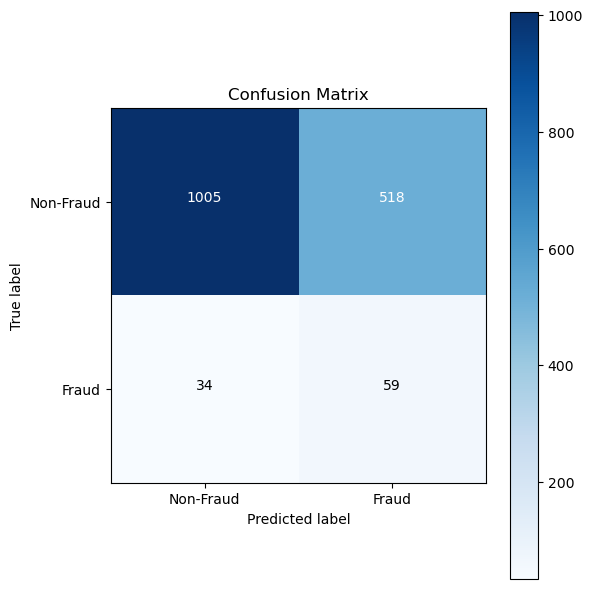

In [81]:
def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(6, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Non-Fraud', 'Fraud'])
    plt.yticks(tick_marks, ['Non-Fraud', 'Fraud'])

    thresh = conf_matrix.max() / 2.0
    for i, j in np.ndindex(conf_matrix.shape):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def evaluate_model(model, model_name, test_images, test_labels, threshold=0.5):
    # ensure test_images and test_labels are compatible
    if test_images.shape[0] != test_labels.shape[0]:
        raise ValueError("Number of test images must match number of labels.")

    # calculate probabilities and predictions
    test_probs = model.predict(test_images).flatten()
    final_predictions = (test_probs > threshold).astype(int)

    # calculate metrics
    fpr, tpr, _ = roc_curve(test_labels, test_probs)
    auc_value = roc_auc_score(test_labels, test_probs)
    precision = precision_score(test_labels, final_predictions)
    recall = recall_score(test_labels, final_predictions)
    ap = average_precision_score(test_labels, test_probs)
    accuracy = accuracy_score(test_labels, final_predictions)
    f1 = f1_score(test_labels, final_predictions)
    conf_matrix = confusion_matrix(test_labels, final_predictions)

    # print performance metrics
    print(f"{model_name} Model Metrics:")
    print(f"Threshold: {threshold}")  
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    # visualize the confusion matrix
    plot_confusion_matrix(conf_matrix)

    # return all necessary metrics
    return fpr, tpr, auc_value, precision, recall, ap, accuracy, threshold, f1, conf_matrix

# evaluate the model using denoised images
fpr, tpr, auc_value, precision, recall, ap, accuracy, threshold, f1, conf_matrix = evaluate_model(
    test_classification_model, 'CNN Binary Classification', denoised_test_images, test_labels
)

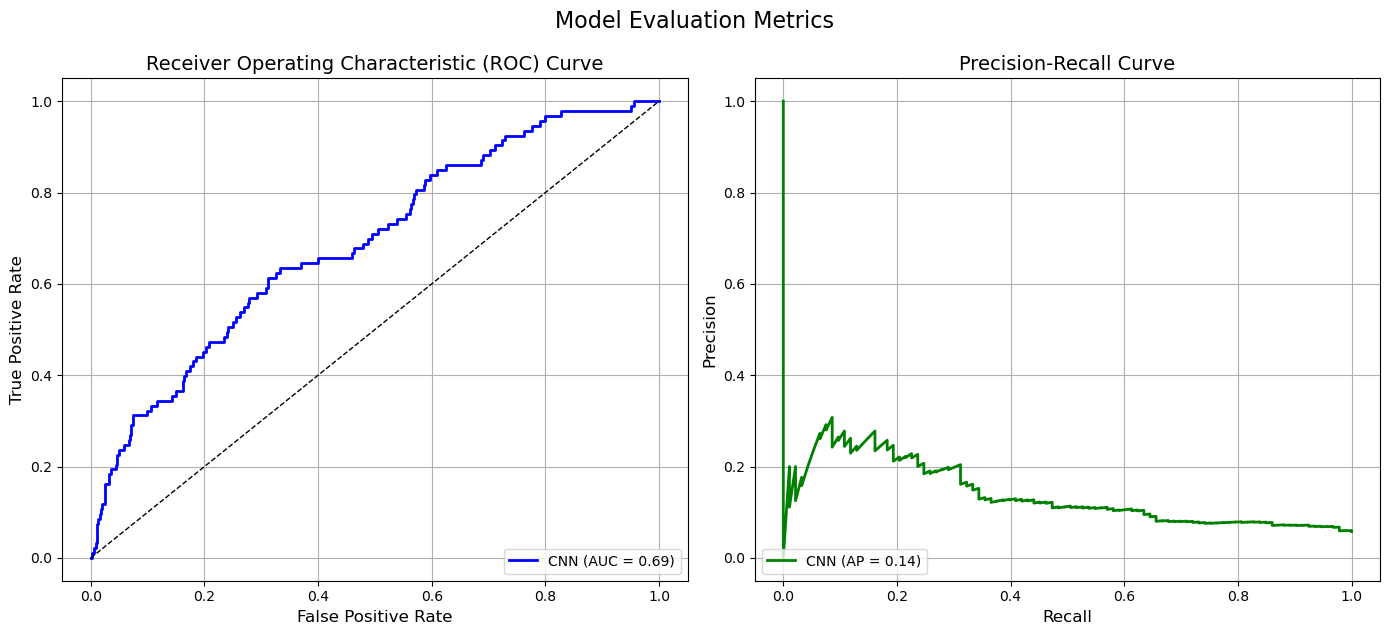

In [82]:
# calculate ROC curve and AUC using the model predictions on denoised test images
fpr, tpr, thresholds = roc_curve(test_labels, test_probs)
auc_value = roc_auc_score(test_labels, test_probs)  # calculate AUC directly

# calculate Precision-Recall curve
precision_vals, recall_vals, _ = precision_recall_curve(test_labels, test_probs)
ap = average_precision_score(test_labels, test_probs)  

# create a figure for the plots
plt.figure(figsize=(14, 6))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'CNN (AUC = {auc_value:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)  # Diagonal line
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc='lower right')
plt.grid()

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall_vals, precision_vals, color='green', lw=2, label=f'CNN (AP = {ap:.2f})')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14)
plt.legend(loc='lower left')
plt.grid()

# adjust layout
plt.tight_layout()
plt.suptitle('Model Evaluation Metrics', fontsize=16, y=1.05)

# show the plots
plt.show()

51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.6550 - loss: 0.8468
Test Loss: 0.8501, Test Accuracy: 65.84%


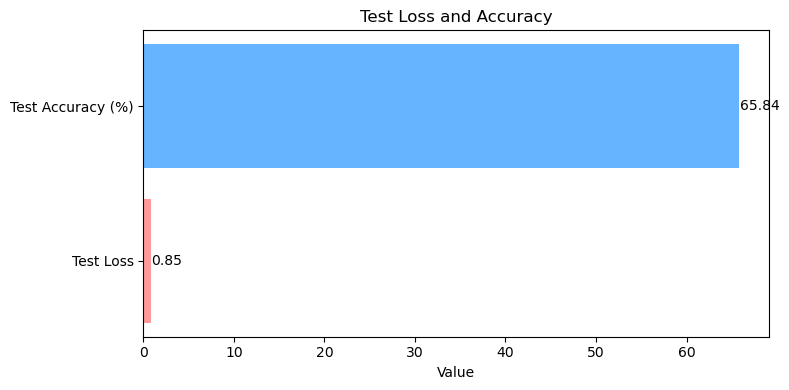

In [83]:
# evaluate the model on the denoised test images
test_loss, test_accuracy = test_classification_model.evaluate(denoised_test_images, test_labels, verbose=1)

# print the evaluation results
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")

# create a bar chart for loss and accuracy
metrics = ['Test Loss', 'Test Accuracy (%)']
values = [test_loss, test_accuracy * 100]

# create the figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# create the bar chart with horizontal bars
bars = ax.barh(metrics, values, color=['#ff9999', '#66b3ff'])

# set labels and title
ax.set_xlabel('Value')
ax.set_title('Test Loss and Accuracy')

# display the value of each bar on the right
for bar in bars:
    ax.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2, f"{bar.get_width():.2f}", 
            color='black', va='center', fontsize=10)

# show the plot
plt.tight_layout()  
plt.show()

In [88]:
# function to load unlabelled validation images
def load_unalabelled_images_from_directory(directory, label=None):
    images = []
    labels = []
    
    for root, _, files in os.walk(directory):
        for file in files:
            if is_image_file(file):
                image_path = os.path.join(root, file)
                image = load_img(image_path, target_size=(128, 128))  # load image
                image = img_to_array(image)  # convert to array
                images.append(image)
                
                # append label if provided
                if label is not None:
                    labels.append(label)
    
    images = np.array(images)
    
    if label is not None:
        labels = np.array(labels)
        return images, labels
    
    return images

In [90]:
# load validation images from the 'sol' directory
val_dir = os.path.join(directory, 'sol')
val_images = load_unalabelled_images_from_directory(val_dir)

# check if validation images are loaded
if val_images is None or len(val_images) == 0:
    raise ValueError("Validation images could not be loaded. Please check the validation directory, named 'sol'.")
else:
    print(f"Validation images loaded successfully. Shape: {val_images.shape}")

Validation images loaded successfully. Shape: (3462, 128, 128, 3)


In [91]:
# reshape denoised validation images back to original shape (128, 128, 3)
val_images_reshaped = val_images.reshape((-1, 128, 128, 3))

# load the classification model
model_name = 'combined_gan_aug_cnn_best_model.keras'
classification_model = load_model(model_name)
print(f"Model '{model_name}' loaded successfully.")

# predict probabilities for validation images
val_probs = classification_model.predict(val_images_reshaped)
val_labels = val_probs.round().astype(int).flatten()

# verify the shape of the validation images and labels
print(f"Validation Images Shape: {val_images_reshaped.shape}")
print(f"Predicted Validation Labels Shape: {val_labels.shape}")

Model 'combined_gan_aug_cnn_best_model.keras' loaded successfully.
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step
Validation Images Shape: (3462, 128, 128, 3)
Predicted Validation Labels Shape: (3462,)


In [99]:
# function to get all image paths in a directory
def get_image_paths_from_directory(directory):
    image_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if is_image_file(file):
                image_paths.append(os.path.join(root, file))
    return image_paths

In [101]:
# create a DataFrame for the validation predictions
val_image_paths = get_image_paths_from_directory(val_dir)
val_predictions = pd.DataFrame({'image_path': val_image_paths, 'predicted_label': val_labels})

# add a column for fraud and non-fraud labels
val_predictions['classified'] = val_predictions['predicted_label'].apply(lambda x: 'fraud' if x == 1 else 'non-fraud')

print('Fraud count:', val_predictions[val_predictions['predicted_label'] == 1].shape[0])
print('Non_Fraud count:', val_predictions[val_predictions['predicted_label'] == 0].shape[0])

Fraud count: 1433
Non_Fraud count: 2029


In [103]:
# export to CSV
val_predictions.to_csv('combined_gan_aug_cnn_validation_predictions.csv', index=False)
print("Validation predictions have been exported to cnn_validation_predictions.csv")

Validation predictions have been exported to cnn_validation_predictions.csv


In [105]:
# function to load and preprocess the images
def load_validated_and_preprocess_image(img_path):
    # load the image
    img = Image.open(img_path)
    # resize to the expected input shape of your CNN
    img = img.resize((128, 128))
    # convert to numpy array and normalize pixel values to [0, 1]
    img_array = np.array(img) / 255.0
    
    return img_array

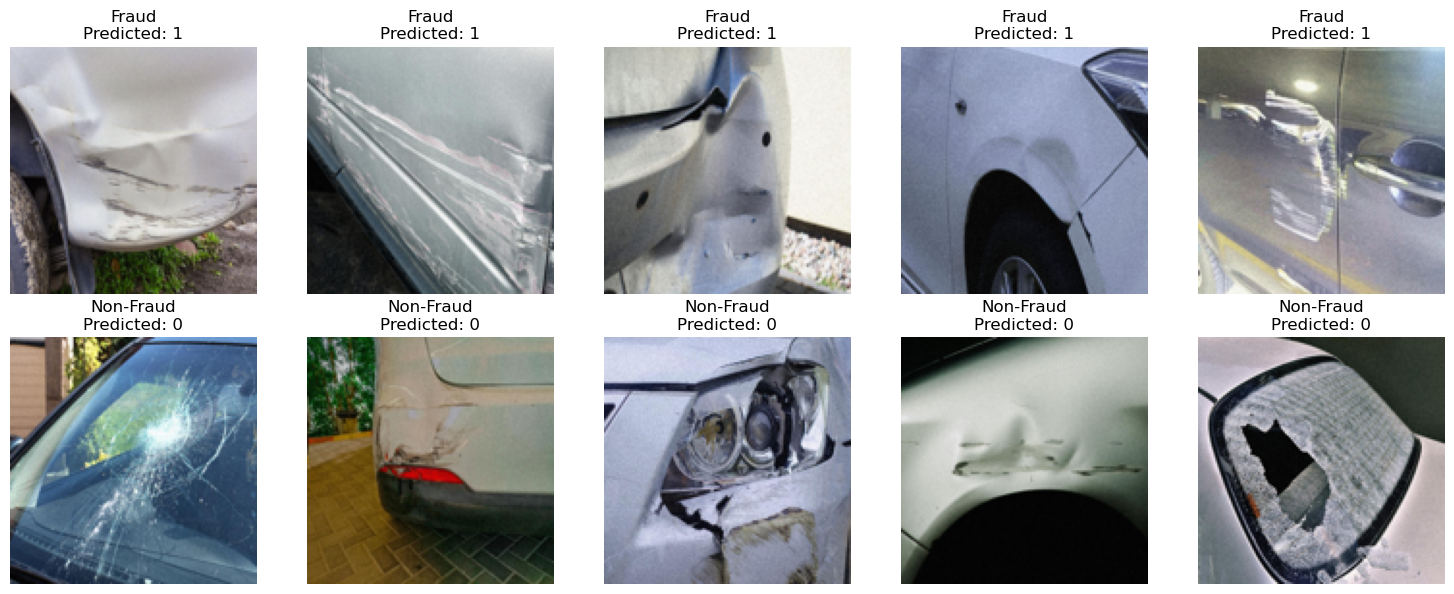

In [107]:
# function to plot fraud and non-fraud images along with their predicted labels
def plot_images(val_predictions, n=5):
    # filter fraud and non-fraud images
    fraud_images = val_predictions[val_predictions['predicted_label'] == 1]
    non_fraud_images = val_predictions[val_predictions['predicted_label'] == 0]
    
    # sample images safely
    num_fraud_samples = min(len(fraud_images), n)
    num_non_fraud_samples = min(len(non_fraud_images), n)

    # randomly sample images
    fraud_sample = fraud_images.sample(num_fraud_samples) if num_fraud_samples > 0 else pd.DataFrame(columns=val_predictions.columns)
    non_fraud_sample = non_fraud_images.sample(num_non_fraud_samples) if num_non_fraud_samples > 0 else pd.DataFrame(columns=val_predictions.columns)

    # create subplots
    fig, axes = plt.subplots(2, n, figsize=(15, 6))
    
    # plot fraud images
    for i, (index, row) in enumerate(fraud_sample.iterrows()):
        img_path = row['image_path']
        img = load_validated_and_preprocess_image(img_path)
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"Fraud\nPredicted: {row['predicted_label']}")
        axes[0, i].axis('off')
    
    # plot non-fraud images
    for i, (index, row) in enumerate(non_fraud_sample.iterrows()):
        img_path = row['image_path']
        img = load_validated_and_preprocess_image(img_path)
        axes[1, i].imshow(img)
        axes[1, i].set_title(f"Non-Fraud\nPredicted: {row['predicted_label']}")
        axes[1, i].axis('off')

    # adjust layout and display
    plt.tight_layout()
    plt.show()

# display a few fraud and non-fraud images
plot_images(val_predictions, n=5)
